# Statistical Analysis: Genius Song Lyrics Subset (1%)

**Dataset:** 34'049 Songs | 26'408 Artists | 6 Genres

**Genres:**
* Rap / Hip-Hop
* Rock
* Pop
* R&B (Rhythm and Blues)
* Country
* Miscellaneous (various other genres)

**Purpose:** Explore statistical patterns in song lyrics across genres and artists. This includes descriptive statistics of the dataset, word-level metrics (vocabulary size, word frequency distributions, Zipf’s law), and n-gram analyses to examine stylistic and linguistic patterns.

---

# 1. Dataset Overview
## 1.1 Import Packages and Settings

In [34]:
import pandas as pd
import re
from collections import defaultdict, Counter
from itertools import tee
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
import os
import ast
import json

In [35]:
plt.style.use('default')
%matplotlib inline
FIG_DIR = "documentation/statistical_analysis"
os.makedirs(FIG_DIR, exist_ok=True)

## 1.2 Load Dataset

In [36]:
df = pd.read_csv('data/clean/data.csv')

# convert string representations of lists back into actual Python lists
for col in ["words", "tokens"]:
    if isinstance(df[col].iloc[0], str):
        df[col] = df[col].apply(ast.literal_eval)

print(f"DataFrame shape: {df.shape}")
print(f"Number of Songs: {len(df)} | Artists: {df['artist'].nunique()}")
df.head()

DataFrame shape: (34049, 15)
Number of Songs: 34049 | Artists: 26408


,title,tag,artist,year,views,features,id,language_cld3,language_ft,language,lyrics,words,word_count,tokens,token_count
0,2 Is Better 棍子,rap,Chris Travis,2017,4437,{},3036329,en,en,en,Bitch I'm clean Two sticks like Chow Mein Two ...,"[bitch, im, clean, two, sticks, like, chow, me...",294,"[bitch, clean, two, sticks, like, chow, mein, ...",196
1,Scottie,rap,KrJ,2012,89,{},72180,en,en,en,My old girl left me on her old bull shit So I ...,"[my, old, girl, left, me, on, her, old, bull, ...",199,"[old, girl, left, old, bull, shit, play, off, ...",108
2,Pirate Password,rock,The never land pirate band,2011,175,{},2122100,en,en,en,Avast there matey haha If a pirate asks ya for...,"[avast, there, matey, haha, if, a, pirate, ask...",215,"[avast, there, matey, haha, pirate, asks, pass...",149
3,Indri,rock,Puta Volcano,2015,14,{},6889288,en,en,en,Just throw a glimpse under the shell Ghostly v...,"[just, throw, a, glimpse, under, the, shell, g...",162,"[just, throw, glimpse, shell, ghostly, voices,...",103
4,Maps,misc,ANBARDA,2018,4,{},3735887,en,en,en,I miss the taste of a sweeter life I miss the ...,"[i, miss, the, taste, of, a, sweeter, life, i,...",428,"[miss, taste, sweeter, life, miss, conversatio...",176


## 1.3 Descriptive Statistics
Before diving deeper into the analysis, we start with some basic descriptive statistics. First, we examine the genre distribution within the dataset. Then, we analyze characteristics of the lyrics themselves — such as the total number of lyrics and words, as well as the average, minimum, and maximum word counts — both before and after removing stopwords.

In [37]:
# Genre distribution
print("\nGENRE DISTRIBUTION")
print("=" * 60)
category_counts = df['tag'].value_counts().sort_values(ascending=False)

for tag,count in category_counts.items():
    pct = (count / len(df)) * 100
    print(f"{tag}: {count:,} songs ({pct:.2f}%)")


GENRE DISTRIBUTION
pop: 14,100 songs (41.41%)
rap: 9,723 songs (28.56%)
rock: 6,375 songs (18.72%)
rb: 1,531 songs (4.50%)
misc: 1,450 songs (4.26%)
country: 870 songs (2.56%)


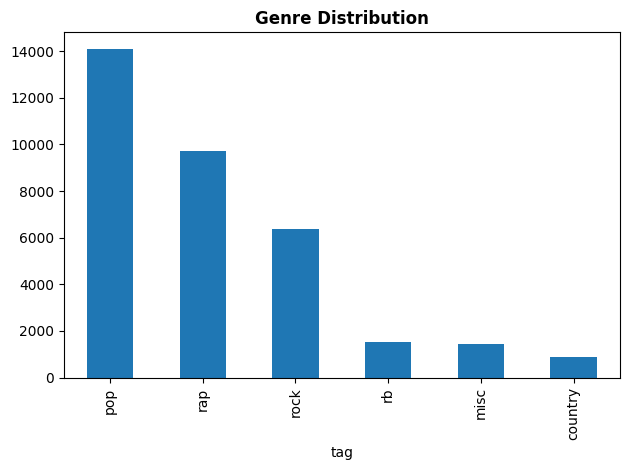

In [61]:
category_counts.plot(kind="bar")
plt.title("Genre Distribution", fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "genre_distribution.png"), dpi=150)
plt.show()
plt.close()

In [39]:
total_lyrics = len(df)
total_words_raw = df["word_count"].sum()
avg_words_raw = df["word_count"].mean()
min_words_raw = df["word_count"].min()
max_words_raw = df["word_count"].max()

print("TEXT STATISTICS")
print("=" * 60)
print(f"Total lyrics (songs):     {total_lyrics:,}")
print(f"Total words:              {total_words_raw:,}")
print(f"Average words/lyric:      {avg_words_raw:.2f}")
print(f"Shortest lyric:           {min_words_raw} words")
print(f"Longest lyric:            {max_words_raw} words")

# TEXT STATISTICS plot
plt.figure()
plt.bar(["min", "avg", "max"], [min_words_raw, avg_words_raw, max_words_raw])
plt.title("Text Statistics (word_count)", fontweight='bold')
plt.ylabel("Words per lyric")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "text_statistics.png"), dpi=150)
plt.close()



TEXT STATISTICS
Total lyrics (songs):     34,049
Total words:              10,596,323
Average words/lyric:      311.21
Shortest lyric:           8 words
Longest lyric:            17434 words


In [40]:
tokens_per_row = df["tokens"]
tokens = [t for row in tokens_per_row for t in row]

total_lyrics = len(df)
total_tokens = len(tokens)
unique_tokens = len(set(tokens))
avg_tokens = df["token_count"].mean()
min_tokens = df["token_count"].min()
max_tokens = df["token_count"].max()

print("TOKEN STATISTICS")
print("=" * 60)
print(f"Total lyrics (songs):     {total_lyrics:,}")
print(f"Total tokens:             {total_tokens:,}")
print(f"Unique tokens:            {unique_tokens:,}")
print(f"Average tokens/lyric:     {avg_tokens:.2f}")
print(f"Shortest lyric:           {min_tokens} tokens")
print(f"Longest lyric:            {max_tokens} tokens")

# TOKEN STATISTICS plot
plt.figure()
plt.bar(["min", "avg", "max"], [min_tokens, avg_tokens, max_tokens])
plt.title("Token Statistics (token_count)", fontweight='bold')
plt.ylabel("Tokens per lyric")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "token_statistics.png"), dpi=150)
plt.close()

TOKEN STATISTICS
Total lyrics (songs):     34,049
Total tokens:             5,999,753
Unique tokens:            127,555
Average tokens/lyric:     176.21
Shortest lyric:           4 tokens
Longest lyric:            9578 tokens


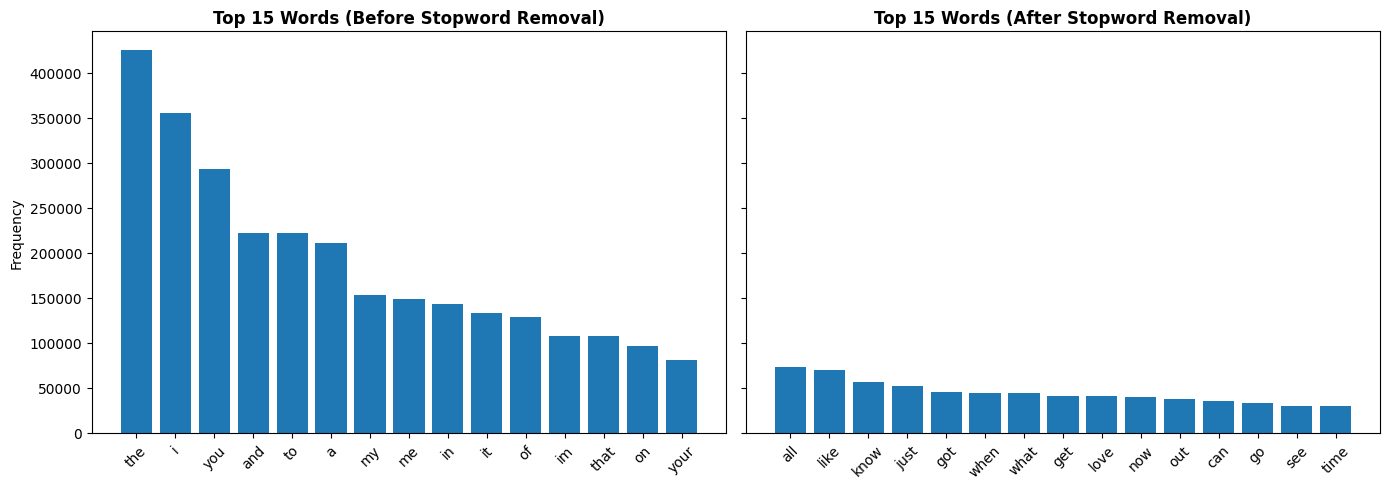

In [41]:
top_n = 15
words = [t for row in df["words"] for t in row]
tokens_filtered = [t for row in df["tokens"] for t in row]

word_counts_raw = Counter(words).most_common(top_n)
word_counts_filtered = Counter(tokens_filtered).most_common(top_n)

df_raw = pd.DataFrame(word_counts_raw, columns=["word", "count"])
df_filtered = pd.DataFrame(word_counts_filtered, columns=["word", "count"])


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(df_raw["word"], df_raw["count"])
axes[0].set_title(f"Top {top_n} Words (Before Stopword Removal)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(df_filtered["word"], df_filtered["count"])
axes[1].set_title(f"Top {top_n} Words (After Stopword Removal)", fontsize=12, fontweight='bold')
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(FIG_DIR, "top15_words_before_after_stopwords.png"), dpi=150)
plt.close(fig)

The plots above show the frequency of the 15 most common words before and after removing stopwords. We can clearly see that removing stopwords makes a significant difference: the most frequent word after filtering does not even appear among the top 15 words before stopword removal.

---
# 2. Word-Level Analysis

Now we take a deeper look at the lyrics and words by analyzing the vocabulary, examining Zipf’s law, identifying rare words (hapax legomena), and exploring various category statistics.

## 2.1 Vocabulary Statistics

In [42]:
# get all words
all_tokens = [token for tokens in df["words"] for token in tokens]

# count unique words
word_counts = Counter(all_tokens)
vocab_size = len(word_counts)
type_token_ratio = vocab_size / len(all_tokens)

print("VOCABULARY STATISTICS")
print("=" * 60)
print(f"Total word tokens:          {len(all_tokens):,}")
print(f"Unique words (vocabulary):  {vocab_size:,}")
print(f"Type-token ratio:           {type_token_ratio:.4f}")

VOCABULARY STATISTICS
Total word tokens:          10,596,323
Unique words (vocabulary):  127,659
Type-token ratio:           0.0120


On average, each word appears roughly 100 times in the dataset, indicating a high level of repetition.

The type–token ratio (TTR) of 0.012 is relatively low, which was to be expected since the corpus consists of song lyrics — a genre characterized by recurring words, refrains, and limited lexical variety compared to other types of text.

## 2.2 Zipf's Law Analysis

**Zipf's Law:** In natural language, word frequency is inversely proportional to rank.

Mathematical form: **f(r) = C / r^α**

Where:
- f(r) = frequency at rank r
- α = slope (ideal = -1.0 for natural language)
- C = coefficient

If α = -1.0, then rank 2 word appears half as often as rank 1, rank 3 appears 1/3 as often, etc.

In [43]:
all_word_freq = Counter(words).most_common(100)
ranks = list(range(1, len(all_word_freq) + 1))
frequencies = [freq for word, freq in all_word_freq]

# Fit power law model (top 100 words)
log_ranks_100 = np.log(ranks).reshape(-1, 1)
log_freq_100 = np.log(frequencies)

model = LinearRegression()
model.fit(log_ranks_100, log_freq_100)

r_squared = model.score(log_ranks_100, log_freq_100)
slope = model.coef_[0]
intercept = model.intercept_
coefficient_C = np.exp(intercept)

print("ZIPF'S LAW ANALYSIS")
print("=" * 60)
print(f"Fitted equation: f(r) = {coefficient_C:.2f} / r^{abs(slope):.3f}")
print(f"\nModel parameters:")
print(f"  Slope (α):         {slope:.4f}")
print(f"  R^2 (fit quality): {r_squared:.4f}")
print(f"  Ideal Zipf slope:  -1.0000")
print(f"  Deviation:         {abs(slope + 1.0):.4f}")

ZIPF'S LAW ANALYSIS
Fitted equation: f(r) = 788840.86 / r^0.828

Model parameters:
  Slope (α):         -0.8284
  R^2 (fit quality): 0.9845
  Ideal Zipf slope:  -1.0000
  Deviation:         0.1716


In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Log-log plot
axes[0].loglog(ranks, frequencies, 'o', alpha=0.7, color='steelblue', label='Actual')
fitted_zipf = [coefficient_C / (r ** abs(slope)) for r in ranks]
axes[0].loglog(ranks, fitted_zipf, 'g-', linewidth=2, alpha=0.8, label=f'Fitted (α={abs(slope):.3f})')
ideal_zipf = [frequencies[0] / r for r in ranks]
axes[0].loglog(ranks, ideal_zipf, 'r--', linewidth=2, alpha=0.7, label='Ideal Zipf (α=1.0)')
axes[0].set_xlabel('Rank (log scale)')
axes[0].set_ylabel('Frequency (log scale)')
axes[0].set_title("Zipf's Law: Actual vs Fitted vs Ideal", fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top 30 comparison
n = 30
axes[1].plot(ranks[:n], frequencies[:n], 'o', color='steelblue', label='Actual')
axes[1].plot(ranks[:n], [coefficient_C / (r ** abs(slope)) for r in ranks[:n]],
             'g-', label=f'Fitted (α={abs(slope):.3f})', linewidth=2, alpha=0.7)
axes[1].plot(ranks[:n], [frequencies[0] / r for r in ranks[:n]],
             'r--', label='Ideal Zipf (a=1.0)', linewidth=2, alpha=0.6)
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 30 Words: Detailed Comparison', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "zipf_loglog_and_top30.png"), dpi=150)
plt.close(fig)
plt.show()

zipf_stats = {
    "C": float(coefficient_C),
    "alpha": float(slope),
    "r2": float(r_squared),
    "ideal_slope": -1.0,
    "deviation": float(abs(slope + 1.0)),
}

with open(os.path.join(FIG_DIR, "zipf_stats.json"), "w") as f:
    json.dump(zipf_stats, f, indent=2)

The fitted Zipf’s Law model shows a slope of −0.83 with an $R^2$ of 0.98, indicating an excellent fit to the expected distribution.

Although the slope is slightly flatter than the ideal −1.0, this small deviation (0.17) suggests that the frequency–rank relationship in the lyrics follows Zipf’s Law closely — common words are used much more frequently than rare ones, as typically observed in song lyrics.

## 2.3 Hapax Legomena (Rare Words)

**Hapax legomena** = words appearing only once in the corpus

These are the rarest words. High hapax count suggests diverse vocabulary.

In [45]:
# Find hapax legomena
word_counts = Counter(words)
hapax = [word for word, count in word_counts.items() if count == 1]
hapax_pct = (len(hapax) / vocab_size) * 100

# Find words appearing 2-5 times
rare_2 = [word for word, count in word_counts.items() if count == 2]
rare_3_5 = [word for word, count in word_counts.items() if 3 <= count <= 5]
rare_le_5 = len(hapax) + len(rare_2) + len(rare_3_5)

print("RARE WORDS ANALYSIS")
print("=" * 60)
print(f"Hapax legomena (count=1):     {len(hapax):,} words ({hapax_pct:.1f}% of vocab)")
print(f"Words appearing twice:        {len(rare_2):,} words")
print(f"Words appearing 3-5 times:    {len(rare_3_5):,} words")
print(f"\nTotal rare words (≤5 times):  {rare_le_5:,} words ({(rare_le_5 / vocab_size) * 100:.1f}% of vocab)")
print(f"\nExamples of hapax legomena:")
print(f"  {hapax[:10]}")

RARE WORDS ANALYSIS
Hapax legomena (count=1):     62,051 words (48.6% of vocab)
Words appearing twice:        15,719 words
Words appearing 3-5 times:    17,093 words

Total rare words (≤5 times):  94,863 words (74.3% of vocab)

Examples of hapax legomena:
  ['shitforeal', 'denimits', 'matey', 'yohoho', 'yohohoyohoho', 'hahaher', 'swabs', 'bosun', 'yed', 'affydavy']


A large proportion of the vocabulary in the lyrics is rare: 48.6% are hapax legomena (appearing only once), and 74.3% of all words occur five times or fewer. A few words are repeated frequently, while most words are unique or very infrequent.

In [46]:
freq_distribution = Counter(word_counts.values())
freq_bins = sorted(freq_distribution.keys())[:20]  # First 20 bins
freq_counts = [freq_distribution[f] for f in freq_bins]

plt.figure()
plt.bar(freq_bins, freq_counts, color='steelblue', edgecolor='black')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Distribution: How Many Words Appear X Times?', fontweight='bold')
plt.xticks(freq_bins)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rare_words_distribution.png"), dpi=150)
plt.close()
plt.show()

rare_stats = {
    "hapax_count": len(hapax),
    "hapax_pct": hapax_pct,
    "rare_le_5": rare_le_5,
    "rare_le_5_pct": (rare_le_5 / vocab_size) * 100,
    "example_hapax": hapax[:10],
}

with open(os.path.join(FIG_DIR, "rare_words_stats.json"), "w") as f:
    json.dump(rare_stats, f, indent=2)

The distribution shows that many words appear only once or very rarely in song lyrics. This is somewhat surprising, as one might expect the opposite: most words occurring very frequently and a few words appearing rarely. However, a closer look at the hapax legomena reveals that these are often words like `['shitforeal', 'denimits', 'matey', 'yohoho', 'yohohoyohoho', 'hahaher', 'swabs', 'bosun', 'yed', 'affydavy']` — not meaningful words in the usual sense, but rather strings or invented terms that mimic sounds made by the singer.

## 2.4 Category Statistics

In [47]:
categories = df['tag'].unique()

category_stats = {}
for cat in categories:
    cat_df = df[df['tag'] == cat]
    cat_text = ' '.join(cat_df['lyrics'].str.lower())
    cat_words = cat_text.split()
    cat_vocab = len(set(cat_words))

    has_number_pct = sum(any(char.isdigit() for char in lyric) for lyric in cat_df['lyrics']) / len(cat_df) * 100

    category_stats[cat] = {
        'songs': len(cat_df),
        'total_words': len(cat_words),
        'avg_words': len(cat_words) / len(cat_df),
        'vocab': cat_vocab,
        'has_number_pct': has_number_pct
    }

C:\Users\pelle\AppData\Local\Temp\ipykernel_24212\1742126211.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(categories, rotation=45)
C:\Users\pelle\AppData\Local\Temp\ipykernel_24212\1742126211.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(categories, rotation=45)
C:\Users\pelle\AppData\Local\Temp\ipykernel_24212\1742126211.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(categories, rotation=45)


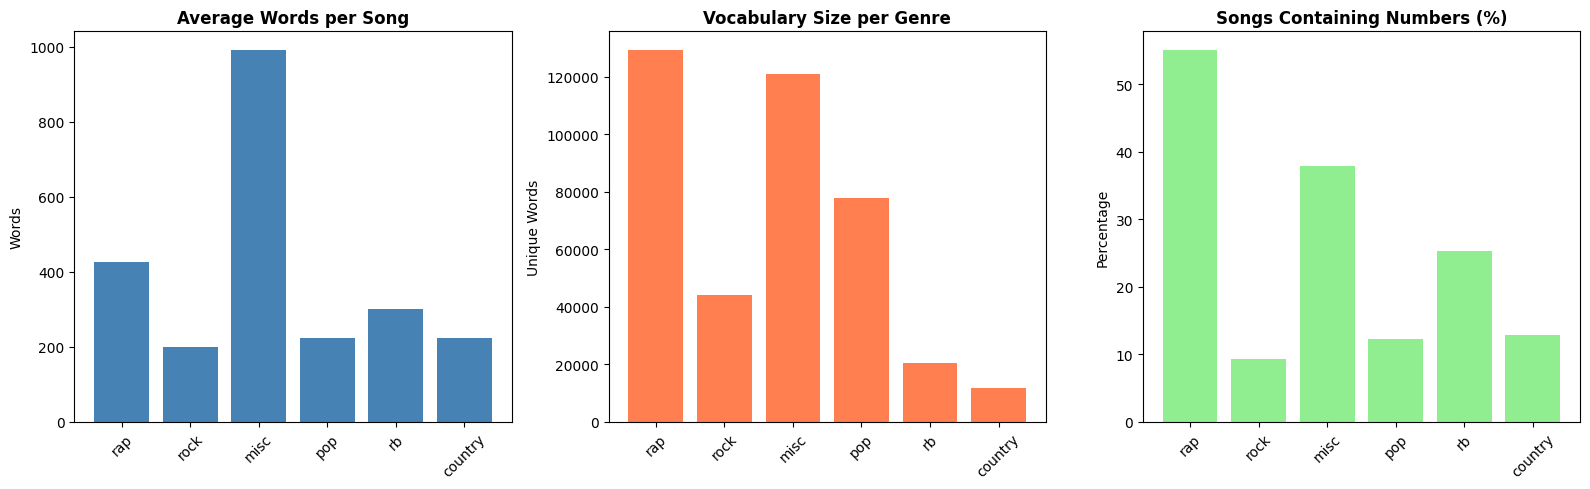

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

avg_words_cat = [category_stats[cat]['avg_words'] for cat in categories]
axes[0].bar(categories, avg_words_cat, color='steelblue')
axes[0].set_title('Average Words per Song', fontweight='bold')
axes[0].set_ylabel('Words')
axes[0].set_xticklabels(categories, rotation=45)

vocab_sizes = [category_stats[cat]['vocab'] for cat in categories]
axes[1].bar(categories, vocab_sizes, color='coral')
axes[1].set_title('Vocabulary Size per Genre', fontweight='bold')
axes[1].set_ylabel('Unique Words')
axes[1].set_xticklabels(categories, rotation=45)

has_number_pct = [category_stats[cat]['has_number_pct'] for cat in categories]
axes[2].bar(categories, has_number_pct, color='lightgreen')
axes[2].set_title('Songs Containing Numbers (%)', fontweight='bold')
axes[2].set_ylabel('Percentage')
axes[2].set_xticklabels(categories, rotation=45)

plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "category_statistics.png"), dpi=150)
plt.show()

Rap appears to have a large vocabulary, which aligns with the presence of rare words we observed earlier. Additionally, numbers occur more frequently in rap songs compared to other genres. In contrast, country songs tend to have a very small vocabulary. Across most genres, the average number of words per song is fairly similar, though rap songs are slightly longer, and songs classified as "Miscellaneous" (`misc`) are noticeably longer—though this category is not easily interpretable as a specific genre.

---
# 3. N-gram Analysis

In this chapter, we analyze n-grams — unigrams, bigrams, and trigrams — to explore common word patterns and recurring phrases. The analysis is conducted both across the entire dataset and broken down by artist and genre to uncover stylistic and genre-specific differences.

## 3.1 Unigram, Bigram, Trigram

In [49]:
def ngrams(tokens, n):
    """generate n-grams"""
    if n <= 0:
        return []
    iters = tee(tokens, n)
    for i, it in enumerate(iters):
        for _ in range(i):
            next(it, None)
    return zip(*iters)

In [50]:
unigram_counts = Counter()
bigram_counts = Counter()
trigram_counts = Counter()

for tokens in df["tokens"]:
    unigram_counts.update(tokens)
    bigram_counts.update(ngrams(tokens, 2))
    trigram_counts.update(ngrams(tokens, 3))

top_unigrams = pd.DataFrame(unigram_counts.most_common(15), columns=["word", "count"])

top_bigrams = pd.DataFrame(
    [(" ".join(k), v) for k, v in bigram_counts.most_common(15)],
    columns=["bigram", "count"]
)
top_trigrams = pd.DataFrame(
    [(" ".join(k), v) for k, v in trigram_counts.most_common(15)],
    columns=["trigram", "count"]
)

In [51]:
print("TOP 15 UNIGRAMS:")
print("=" * 60)
print(top_unigrams)

TOP 15 UNIGRAMS:
    word  count
0    all  73117
1   like  70153
2   know  56895
3   just  52620
4    got  45749
5   when  44654
6   what  44606
7    get  41007
8   love  40835
9    now  40161
10   out  38073
11   can  35417
12    go  33242
13   see  30251
14  time  30185


In [52]:
print("TOP 15 BIGRAMS:")
print("=" * 60)
print(top_bigrams)

TOP 15 BIGRAMS:
        bigram  count
0    know what   5116
1       let go   3589
2    feel like   3476
3    just like   2721
4    right now   2650
5    love love   2521
6     know how   2386
7      can see   2334
8   just wanna   2269
9    know know   2243
10    too much   2026
11   all night   1962
12   what want   1944
13  every time   1919
14    all time   1756


In [53]:
print("TOP 15 TRIGRAMS:")
print("=" * 60)
print(top_trigrams)

TOP 15 TRIGRAMS:
           trigram  count
0   love love love   1039
1      hey hey hey    822
2         da da da    735
3   know know know    638
4      get get get    589
5         go go go    500
6         ah ah ah    495
7      doo doo doo    463
8    one more time    455
9   all night long    449
10  baby baby baby    399
11      let go let    378
12  woah woah woah    359
13       go let go    358
14    never let go    355


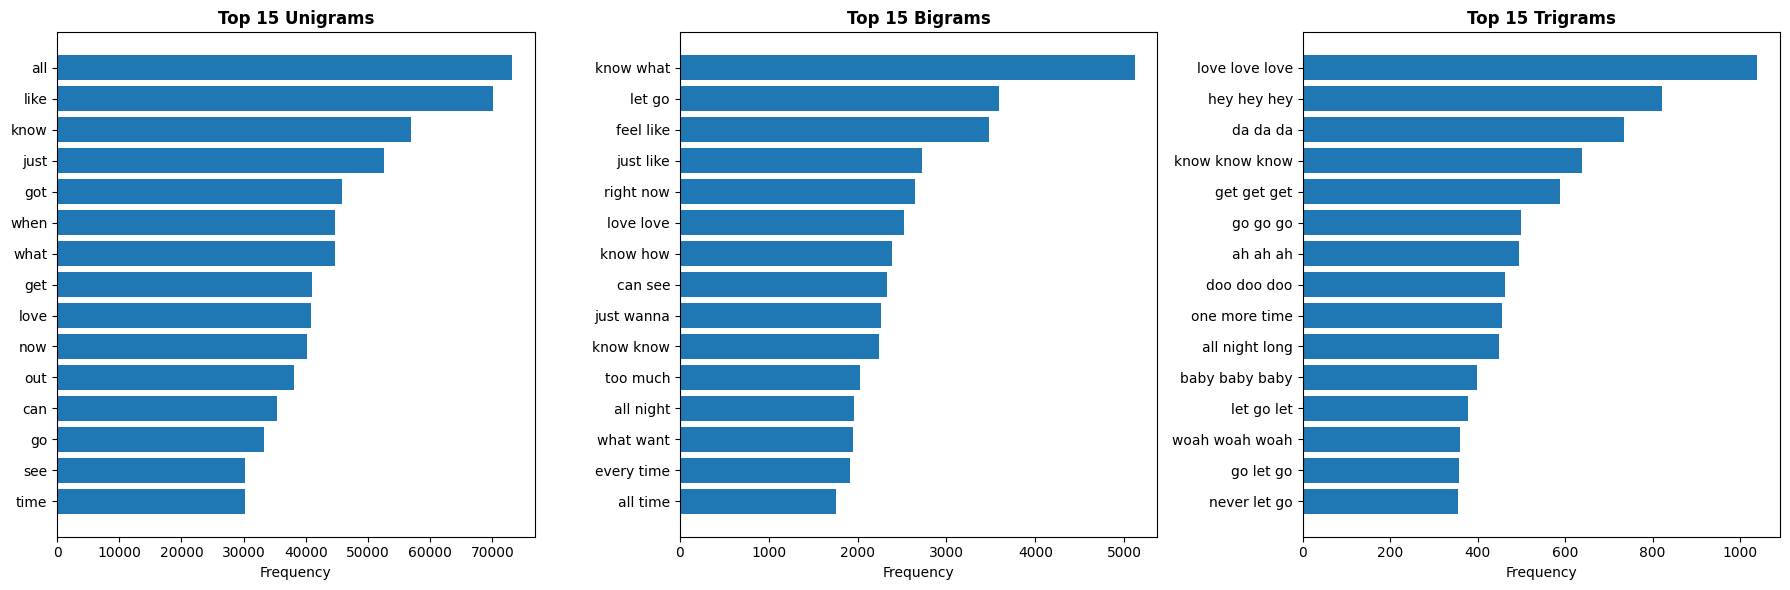

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].barh(top_unigrams["word"][::-1], top_unigrams["count"][::-1])
axes[0].set_title("Top 15 Unigrams", fontweight='bold')
axes[0].set_xlabel("Frequency")

axes[1].barh(top_bigrams["bigram"][::-1], top_bigrams["count"][::-1])
axes[1].set_title("Top 15 Bigrams", fontweight='bold')
axes[1].set_xlabel("Frequency")

axes[2].barh(top_trigrams["trigram"][::-1], top_trigrams["count"][::-1])
axes[2].set_title("Top 15 Trigrams", fontweight='bold')
axes[2].set_xlabel("Frequency")

plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "top15_ngrams.png"), dpi=150)
plt.show()

## 3.2 N-Grams per Artist/Genre

In [55]:
def most_common_ngram_for_group(group_df: pd.DataFrame, label_col: str, n: int) -> pd.DataFrame:
    """
    returns, for each group (artist/tag), the most frequent n-gram along with its count.
    Columns: [label_col, 'ngram', 'count', 'songs']
    """
    rows = []
    for label, sub in group_df.groupby(label_col):
        c = Counter()
        for toks in sub["tokens"]:
            c.update(ngrams(toks, n))
        if c:
            top_ngram, cnt = c.most_common(1)[0]
            rows.append({label_col: label, "ngram": " ".join(top_ngram), "count": cnt, "songs": len(sub)})
        else:
            rows.append({label_col: label, "ngram": None, "count": 0, "songs": len(sub)})
    return pd.DataFrame(rows).sort_values([label_col]).reset_index(drop=True)

In [56]:
top_unigrams_artist = most_common_ngram_for_group(df, "artist", n=1).sort_values("count", ascending=False).head(20)
top_bigrams_artist  = most_common_ngram_for_group(df, "artist", n=2).sort_values("count", ascending=False).head(20)
top_trigrams_artist = most_common_ngram_for_group(df, "artist", n=3).sort_values("count", ascending=False).head(20)

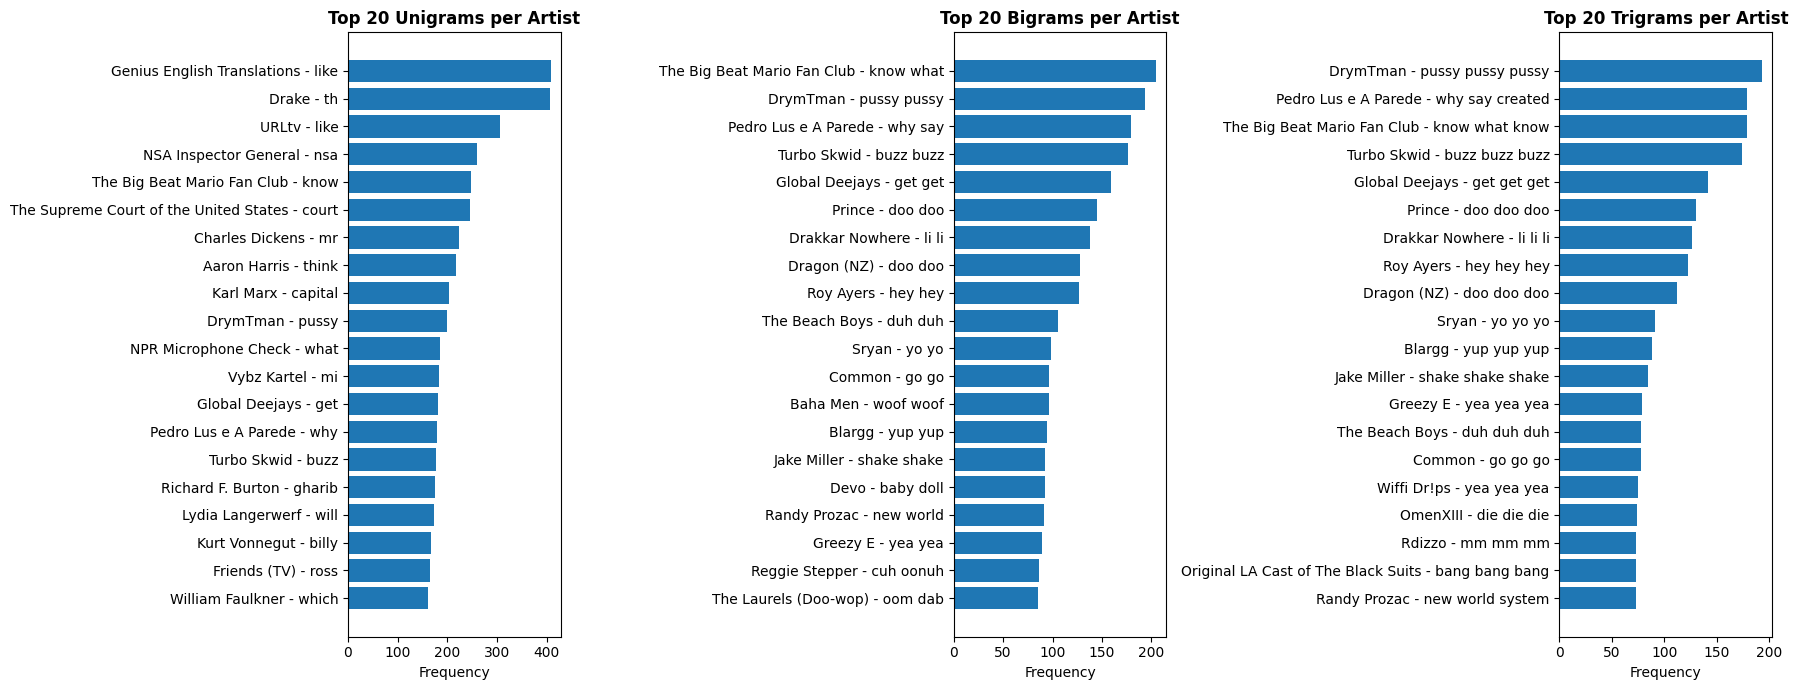

In [64]:
# create labels
top_unigrams_artist["label"] = top_unigrams_artist["artist"] + " - " + top_unigrams_artist["ngram"]
top_bigrams_artist["label"]  = top_bigrams_artist["artist"]  + " - " + top_bigrams_artist["ngram"]
top_trigrams_artist["label"] = top_trigrams_artist["artist"] + " - " + top_trigrams_artist["ngram"]


fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].barh(top_unigrams_artist["label"][::-1], top_unigrams_artist["count"][::-1])
axes[0].set_title("Top 20 Unigrams per Artist", fontweight='bold')
axes[0].set_xlabel("Frequency")

axes[1].barh(top_bigrams_artist["label"][::-1], top_bigrams_artist["count"][::-1])
axes[1].set_title("Top 20 Bigrams per Artist", fontweight='bold')
axes[1].set_xlabel("Frequency")

axes[2].barh(top_trigrams_artist["label"][::-1], top_trigrams_artist["count"][::-1])
axes[2].set_title("Top 20 Trigrams per Artist", fontweight='bold')
axes[2].set_xlabel("Frequency")

plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "top20_ngrams_per_artist.png"), dpi=150)
plt.show()

In [58]:
top_unigrams_genre = most_common_ngram_for_group(df, "tag", n=1).sort_values("count", ascending=False)
top_bigrams_genre  = most_common_ngram_for_group(df, "tag", n=2).sort_values("count", ascending=False)
top_trigrams_genre = most_common_ngram_for_group(df, "tag", n=3).sort_values("count", ascending=False)

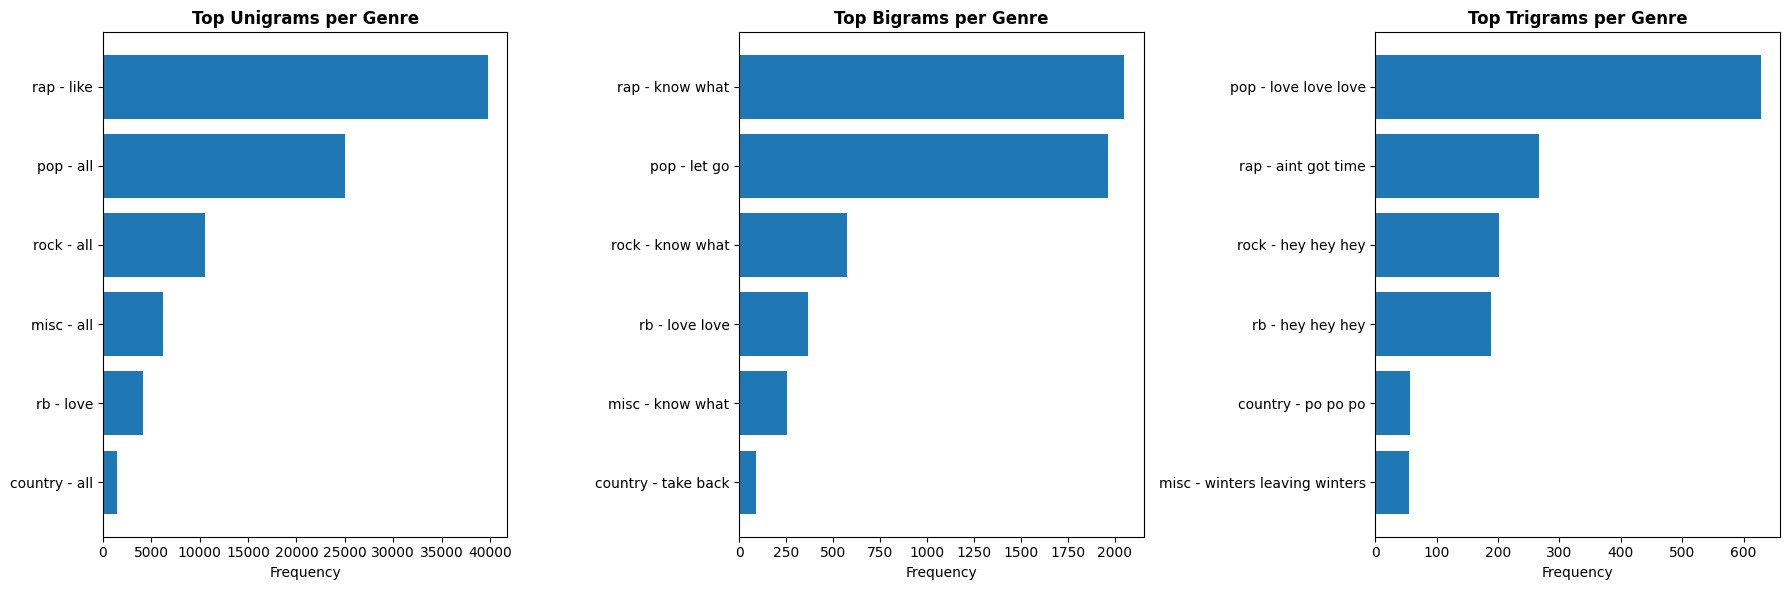

In [65]:
# create labels
top_unigrams_genre["label"] = top_unigrams_genre["tag"] + " - " + top_unigrams_genre["ngram"]
top_bigrams_genre["label"]  = top_bigrams_genre["tag"]  + " - " + top_bigrams_genre["ngram"]
top_trigrams_genre["label"] = top_trigrams_genre["tag"] + " - " + top_trigrams_genre["ngram"]


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].barh(top_unigrams_genre["label"][::-1], top_unigrams_genre["count"][::-1])
axes[0].set_title("Top Unigrams per Genre", fontweight='bold')
axes[0].set_xlabel("Frequency")

axes[1].barh(top_bigrams_genre["label"][::-1], top_bigrams_genre["count"][::-1])
axes[1].set_title("Top Bigrams per Genre", fontweight='bold')
axes[1].set_xlabel("Frequency")

axes[2].barh(top_trigrams_genre["label"][::-1], top_trigrams_genre["count"][::-1])
axes[2].set_title("Top Trigrams per Genre", fontweight='bold')
axes[2].set_xlabel("Frequency")

plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "top_ngrams_per_genre.png"), dpi=150)
plt.show()